# <span style='color:Red'> This code develops an algorithm to read the screenplays and automatically extract the character names from the screenplay and evaluate the model. I developed two different methods to extract character names and compared them with the true label of character names in each movie.  </span>


# Import Libraries

In [340]:
import json
from sklearn.metrics import confusion_matrix
import nltk
from matplotlib import pyplot as plt
import statistics
import re
from collections import defaultdict
from nltk.corpus import stopwords
from pattern.en import parse, Sentence, mood
from pattern.db import csv
from pattern.vector import Document, NB
nltk.download('words')
nltk.download('maxent_ne_chunker')
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
import IPython
from IPython.display import display
import graphviz
from sklearn.tree import export_graphviz

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\14379\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\14379\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


# Data Cleaning:
### 1. Open the movie script file. (Change the file name 'Movie Scripts/Alien-Nation.txt' to any other script in this directory to test different results)
### 2. Since character names in the files format is capital letters and each one is in new line I will extract all words that is capital letters and line characters is less than 10
### 3. Save the extracted words it in a new file (names.txt)

In [412]:
with open(r'Movie Scripts/Alien-Nation.txt') as f, open(r'resources/names.txt', 'w') as f2:
    for line in f:
        line = line.strip()
        if not line or (':' not in line and ',' not in line and ' ' not in line and len(line) < 10 and line.isupper()):
            f2.write(line + '\n')
            
def readText():
    """
    Reads the text from a text file.
    """
    with open("resources/names.txt", "rb") as f:
        text = f.read().decode('utf-8')
    return text

# Extract Characters names using the first method:
### 1. Parses text into parts of speech tagged with parts of speech labels using nltk.
### 2. Creates a local list to hold nodes of tree passed through, extracting named entities from the chunked sentences.
### 3. Uses the global entity list, creating a new dictionary with the properties extended by the local list, without overwriting.
### 4. Brings in stopwords and custom stopwords to filter mismatches out.
### 5. Convert the output list to a data frame.

In [413]:
""" Used for reference: https://github.com/emdaniels/character-extraction """

def chunkSentences(text):
    """
    Parses text into parts of speech tagged with parts of speech labels.

    Used for reference: https://gist.github.com/onyxfish/322906
    """
    sentences = nltk.sent_tokenize(text)
    tokenizedSentences = [nltk.word_tokenize(sentence)
                          for sentence in sentences]
    taggedSentences = [nltk.pos_tag(sentence)
                       for sentence in tokenizedSentences]
    if nltk.__version__[0:2] == "2.":
        chunkedSentences = nltk.batch_ne_chunk(taggedSentences, binary=True)
    else:
        chunkedSentences = nltk.ne_chunk_sents(taggedSentences, binary=True)
    return chunkedSentences

def extractEntityNames(tree, _entityNames=None):
    
    if _entityNames is None:
        _entityNames = []
    try:
        if nltk.__version__[0:2] == "2.":
            label = tree.node
        else:
            label = tree.label()
    except AttributeError:
        pass
    else:
        if label == 'NE':
            _entityNames.append(' '.join([child[0] for child in tree]))
        else:
            for child in tree:
                extractEntityNames(child, _entityNames=_entityNames)
    return _entityNames


def buildDict(chunkedSentences, _entityNames=None):

    if _entityNames is None:
        _entityNames = []

    for tree in chunkedSentences:
        extractEntityNames(tree, _entityNames=_entityNames)

    return _entityNames

def removeStopword(entityNames, customStopWords=None):

    # Memoize custom stop words
    if customStopWords is None:
        with open("resources/customStopWords.txt", "r") as f:
            customStopwords = f.read().split(', ')

    for name in entityNames:
        if name in stopwords.words('english') or name in customStopwords:
            entityNames.remove(name)
            
text = readText()
chunkedSentences = chunkSentences(text)
entityNames = buildDict(chunkedSentences)
removeStopword(entityNames)

def getMajorCharacters(entityNames):
    """
    Adds names to the major character list if they appear frequently.
    """
    x = {name for name in entityNames if ' ' not in name}
    data1 = pd.DataFrame(x, columns=['Method 1'])
    data1 = data1.sort_values('Method 1')
    data1 = data1.reset_index(drop=True)
    return data1
for i in range(25):
    exec(f'df_1 = getMajorCharacters(entityNames)')
df_1

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

# Extract Characters names using the second method:
### 1. Split all the words extracted from the original file that is capital letters, number of characters in the line less than 10, and the name is repeated minimum five times in the script.
### 2. Bring in stopwords and custom stopwords to filter mismatches out.
### 3. Convert the output list to a data frame.

In [416]:
 def readText():
    """
    Reads the text from a text file.
    """
    with open(r"names.txt", "r") as f:
        data1 = f.read()
        data1 = data1.split()
    return data1

def removeStopwords(customStopWords=None):
    """
    Brings in stopwords and custom stopwords to filter mismatches out.
    """
    with open(r"resources/names.txt", "r") as f:
        data1 = f.read()
        data1 = data1.split()
    # Memoize custom stop words
    if customStopWords is None:
        with open("resources/customStopWords.txt", "r") as f:
            customStopwords = f.read().split(', ')
    for name in data1:
        if name in stopwords.words('english') or name in customStopwords or '.' in name or ')' in name:
                data1.remove(name)
    data = {name for name in data1 if data1.count(name) > 5}
    data = pd.DataFrame(data, columns=['Method 2'])
    data = data.drop_duplicates(subset=['Method 2'])
    data = data.sort_values('Method 2')
    data = data.reset_index(drop=True)
    return data
for i in range(25):
    exec(f'df_2 = removeStopwords()')
df_2

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

# Extract Characters names using from available dataset with the true label of character names:
### 1. Extract the character names for each movie
### 2. compare the results with Mehtod one and Method two
### 3. Join three datasets in one dataset Called dataset
### 4. Save the final dataset in a file name 'Movie Name'_results.csv

In [408]:
characters_df = pd.read_csv('True label character names/movie_characters_metadata.tsv', sep='\t', warn_bad_lines=False,error_bad_lines=False, header=None)
characters_df.columns=['chId','True_label','mId','mName','gender','posCredits']
characters_df = characters_df.drop(['gender'], axis=1)
characters_df = characters_df.drop(['posCredits'], axis=1)
characters_df = characters_df.drop(['chId'], axis=1)
characters_df = characters_df.drop(['mId'], axis=1)

In [409]:
df1 =  characters_df[147:162]
df1 = df1.reset_index(drop=True)
df1

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [267]:
dataset1 = pd.concat([df_1,df_2,df1], axis=1)
#dataset1.to_csv(dataset1.mName[0] + '_results.csv', index=True, na_rep="None")
dataset1

,Method 1,Method 2,True_label,mName
0,ANGLE,ANGLE,ANGLE,alien nation
1,CRAIS,CASSANDRA,CASSANDRA,alien nation
2,GOLDRUP,FEDORCHUK,FEDORCHUK,alien nation
3,HARCOURT,HARCOURT,HARCOURT,alien nation
4,JETSON,JETSON,JETSON,alien nation
5,KIPLING,KIPLING,KIPLING,alien nation
6,KRISTIN,O'NEAL,MAFFET,alien nation
7,SYKES,OPERATOR,O'NEAL,alien nation
8,WATSON,PORTER,OPERATOR,alien nation
9,WILTEY,QUINT,PORTER,alien nation


# Evaluate the model performance:
### 1. Calculate the true positive and true negative for each method compared with the true label
### 2. Calculate the Accuracy, Precision, and recall.
### 3. Calculate the mean and Std dev for 10 different movies to find the average result of each method.
### 4. Save final results ( TP, FP,  and Accuracy) in a file name Performance_Evaluation-Method1.csv for first method and Performance_Evaluation-Method2.csv for the second method.

In [310]:
def metrics(truth,run):
    truth = truth
    run = run
    TP = float(len(set(run) & set(truth)))
    if float(len(run)) >= float(TP):
        FP = len(run) - TP
    else:
        FP = TP - len(run)
    TN = 0
    if len(truth) >= len(run):
        FN = len(truth) - len(run)
    else:
        FN = 0
    accuracy = (float(TP)+float(TN))/float(len(truth))
    recall = (float(TP))/float(len(truth))
    precision = float(TP)/(float(FP)+float(TP))
    print("The accuracy is %r" % accuracy)
    print("The recall is %r" % recall)
    print("The precision is %r" % precision)
    d = {'Predicted Negative': [TN,FN], 'Predicted Positive': [FP,TP]}
    metricsdf = pd.DataFrame(d, index=['Negative Cases','Positive Cases'])
    df_a = pd.DataFrame(d, columns=['Predicted Positive'])
    df_a = df_a.rename(columns={"Predicted Positive": "Predicted Positive 10"})
    df_a['Accuracy10'] = accuracy
    df_a.to_csv('Performance_Evaluation.csv', index=True, na_rep="None")
    return metricsdf

In [311]:
metrics(dataset1['Method 1'],dataset1['True_label'])

The accuracy is 0.4375
The recall is 0.4375
The precision is 0.4375


,Predicted Negative,Predicted Positive
Negative Cases,0,9.0
Positive Cases,0,7.0


In [264]:
metrics(dataset1['Method 2'],dataset1['True_label'])

The accuracy is 0.875
The recall is 0.875
The precision is 0.875


,Predicted Negative,Predicted Positive
Negative Cases,0,2.0
Positive Cases,0,14.0


In [330]:
Evaluation_method1 = pd.read_csv('Performance Evaluation/Performance_Evaluation-Method1.csv')
Evaluation_method1

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [331]:
print(Evaluation_method1['Accuracy1'].mean())
print(Evaluation_method1['Accuracy1'].std())

0.4749
0.14221224357354828


In [332]:
Evaluation_method2 = pd.read_csv('Performance Evaluation/Performance_Evaluation-Method2.csv')
Evaluation_method2

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [333]:
print(Evaluation_method2['Accuracy2'].mean())
print(Evaluation_method2['Accuracy2'].std())

0.8393999999999998
0.06254989119805798


<Figure size 1440x576 with 0 Axes>

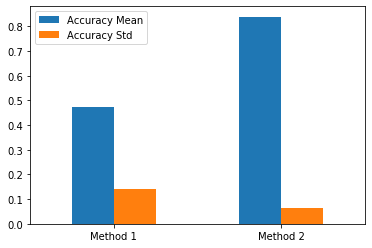

In [407]:
plt.figure(figsize=(20,8))
mean1 = Evaluation_method1['Accuracy1'].mean() 
mean2 = Evaluation_method2['Accuracy2'].mean()
std1 = Evaluation_method1['Accuracy1'].std()
std2 = Evaluation_method2['Accuracy2'].std()
Mean = [mean1, mean2]
Std =  [std1,std2]
values = ['Method 1', 'Method 2']
dfx = pd.DataFrame({'Accuracy Mean': Mean,
                   'Accuracy Std': Std}, index=values)
ax = dfx.plot.bar(rot=0)